## Dependencies

In [1]:
from tweet_utility_scripts import *
from transformers import TFDistilBertModel
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
hold_out = pd.read_csv('/kaggle/input/tweet-dataset-split-distilbert-uncased-128/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']
display(hold_out.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-128/hold_out.tar.gz

base_data_path = 'hold_out/'
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid.npy')

# Delete data dir
shutil.rmtree(base_data_path)

,textID,text,selected_text,sentiment,text_len,selected_text_len,set
0,69a4e7a6f5,"ouch, i'm sorry then",sorry,negative,21,5,train
1,8022534fc2,"thankyou, yes. off to a pre-wedding party now.","Thankyou,",positive,47,9,train
2,f7beb13214,this is how we do itttt,this is how we do itttt,neutral,23,23,train
3,89cdcbfb73,everyone's abandoning the office... i still ha...,everyone's abandoning the office... I still ha...,neutral,62,62,train
4,29a4bb11d9,"acquiring a centos live cd, now where did i pu...",I would like to boot from that. I wonder if I ...,neutral,126,61,train


hold_out/
hold_out/y_train.npy
hold_out/x_train.npy
hold_out/y_valid.npy
hold_out/x_valid.npy


# Model parameters

In [3]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-5
ES_PATIENCE = 3

tokenizer_path = '/kaggle/input/tweet-dataset-split-distilbert-uncased-128/vocab.txt'
base_path = '/kaggle/input/qa-transformers/distilbert/'
base_model_path = base_path + 'distilbert-base-uncased-distilled-squad-tf_model.h5'
config_path = base_path + 'distilbert-base-uncased-distilled-squad-config.json'
model_path = 'model.h5'
log_path = './'

# Model

In [4]:
def model_fn():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFDistilBertModel.from_pretrained(base_model_path, config=config_path, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    last_state = sequence_output[0]
    
    avg_p = GlobalAveragePooling1D()(last_state)
    max_p = GlobalMaxPooling1D()(last_state)
    
    x = Concatenate()([avg_p, max_p])
    
    y_start = Dense(MAX_LEN, activation='softmax', name='y_start')(x)
    y_end = Dense(MAX_LEN, activation='softmax', name='y_end')(x)
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=[metrics.CategoricalAccuracy()])
    
    return model

model = model_fn()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
base_model (TFDistilBertModel)  ((None, 128, 768),)  66362880    attention_mask[0][0]             
                                                                 input_ids[0][0]              

# Train

In [5]:
tb_callback = TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)

history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[es, tb_callback],
                    epochs=EPOCHS, 
                    verbose=1).history

model.save_weights(model_path)

Train on 21988 samples, validate on 5497 samples
Epoch 1/20
21988/21988 [==============================] - 194s 9ms/sample - loss: 3.2357 - y_start_loss: 1.4478 - y_end_loss: 1.7895 - y_start_categorical_accuracy: 0.1871 - y_end_categorical_accuracy: 0.0351 - val_loss: 3.2323 - val_y_start_loss: 1.4688 - val_y_end_loss: 1.7635 - val_y_start_categorical_accuracy: 0.1859 - val_y_end_categorical_accuracy: 0.0413
Epoch 2/20
21988/21988 [==============================] - 182s 8ms/sample - loss: 2.9770 - y_start_loss: 1.3256 - y_end_loss: 1.6523 - y_start_categorical_accuracy: 0.1880 - y_end_categorical_accuracy: 0.0402 - val_loss: 3.7082 - val_y_start_loss: 1.6951 - val_y_end_loss: 2.0130 - val_y_start_categorical_accuracy: 0.1323 - val_y_end_categorical_accuracy: 0.0213
Epoch 3/20
21988/21988 [==============================] - 182s 8ms/sample - loss: 2.9700 - y_start_loss: 1.3168 - y_end_loss: 1.6535 - y_start_categorical_accuracy: 0.1862 - y_end_categorical_accuracy: 0.0368 - val_loss: 4.

In [6]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1586139216.bdd530ad0907.profile-empty
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-06_02-13-36/
train/plugins/profile/2020-04-06_02-13-36/local.trace
train/events.out.tfevents.1586139206.bdd530ad0907.12.5424.v2
validation/
validation/events.out.tfevents.1586139400.bdd530ad0907.12.28123.v2


# Model loss graph

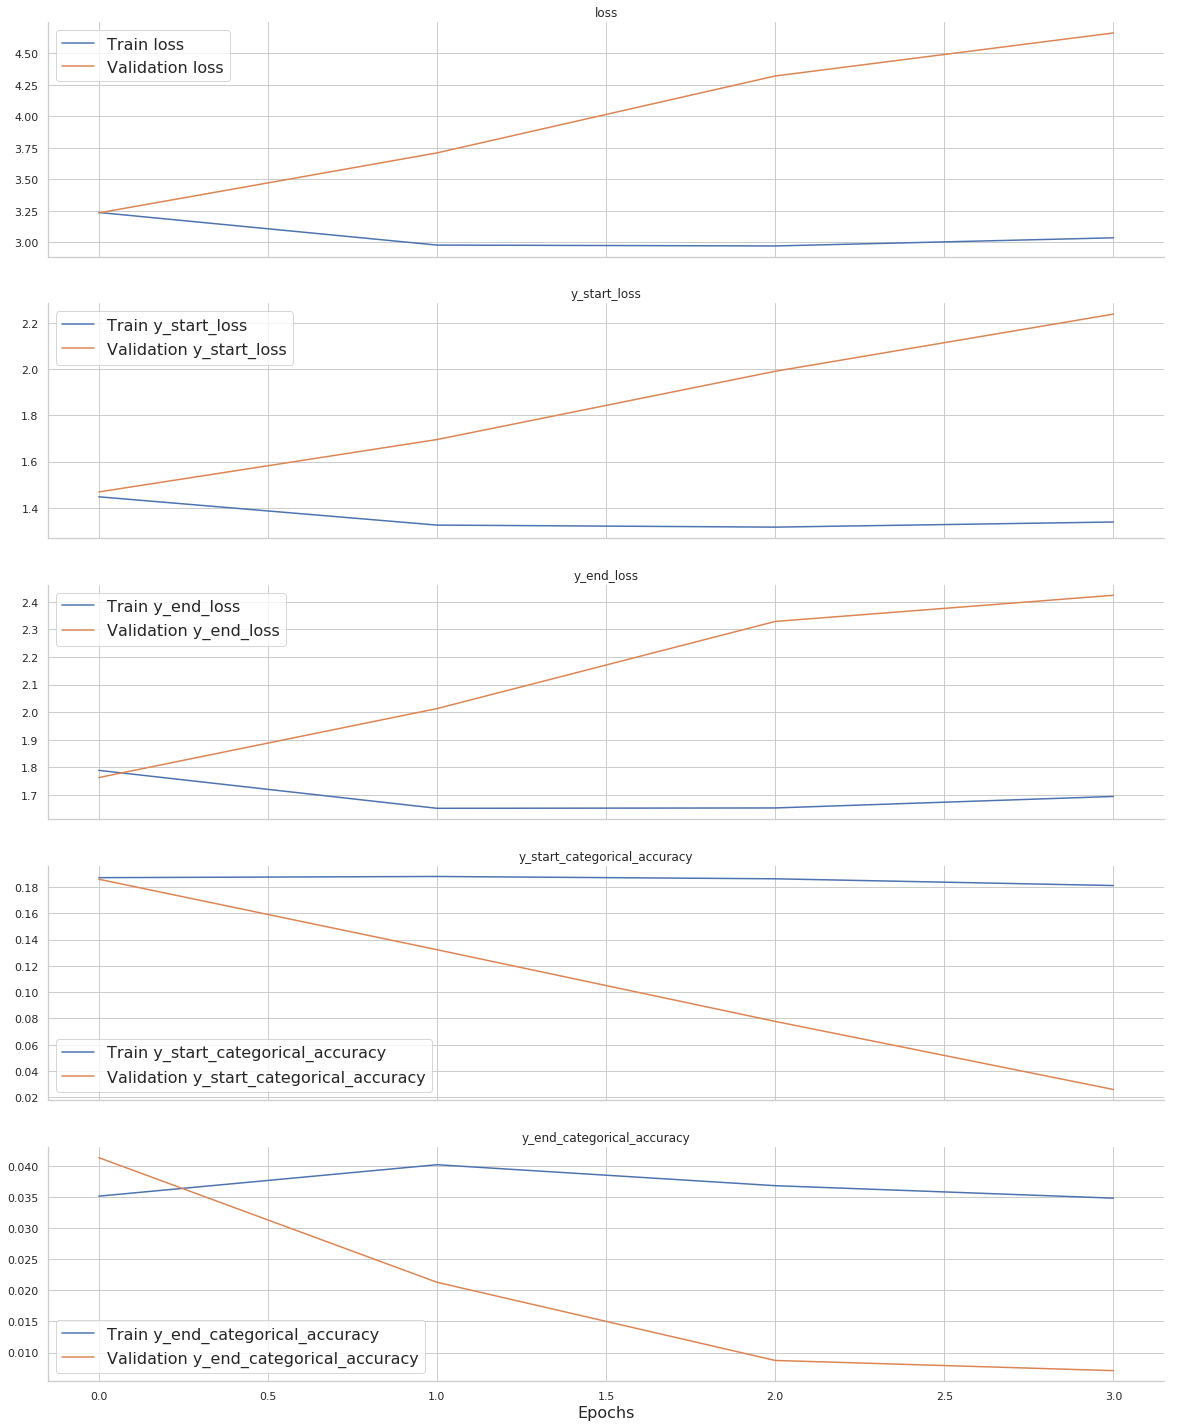

In [7]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 'y_start_categorical_accuracy', 'y_end_categorical_accuracy'])

# Tokenizer

In [8]:
tokenizer = BertWordPieceTokenizer(tokenizer_path , lowercase=True)

# Model evaluation

In [9]:
train_preds = model.predict(list(x_train))
valid_preds = model.predict(list(x_valid))

train['start'] = train_preds[0].argmax(axis=-1)
train['end'] = train_preds[1].argmax(axis=-1)
train['prediction'] = train.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
train["prediction"] = train["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

validation['start'] = valid_preds[0].argmax(axis=-1)
validation['end'] = valid_preds[1].argmax(axis=-1)
validation['prediction'] = validation.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
validation["prediction"] = validation["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
  
evaluate_model(train, validation)

Train set Jaccard: 0.439
Validation set Jaccard: 0.433

Metric by sentiment

	Sentiment == negative
	Train set Jaccard: 0.241 (6142 samples)
	Validation set Jaccard: 0.227 (1644 samples)

	Sentiment == positive
	Train set Jaccard: 0.241 (6948 samples)
	Validation set Jaccard: 0.243 (1634 samples)

	Sentiment == neutral
	Train set Jaccard: 0.730 (8898 samples)
	Validation set Jaccard: 0.726 (2219 samples)

Metric by text length

	Text length between 0 and 50
	Train set Jaccard: 0.611 (7968 samples)
	Validation set Jaccard: 0.595 (1998 samples)

	Text length between 50 and 100
	Train set Jaccard: 0.396 (8816 samples)
	Validation set Jaccard: 0.392 (2186 samples)

	Text length between 100 and 150
	Train set Jaccard: 0.248 (5195 samples)
	Validation set Jaccard: 0.255 (1311 samples)

	Text length between 150 and 200
	Train set Jaccard: 0.109 (9 samples)
	Validation set Jaccard: 0.000 (2 samples)

Metric by selected_text length

	Selected text length between 0 and 50
	Train set Jaccard: 0.3

# Visualize predictions

In [10]:
print('Train set')
display(train.head(10))

print('Validation set')
display(validation.head(10))

Train set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
0,69a4e7a6f5,"ouch, i'm sorry then",sorry,negative,21,5,train,1,5,"ouch, i'",0.000000
1,8022534fc2,"thankyou, yes. off to a pre-wedding party now.","Thankyou,",positive,47,9,train,1,14,"thankyou, yes. off to a pre-wedding party now.",0.125000
2,f7beb13214,this is how we do itttt,this is how we do itttt,neutral,23,23,train,1,5,this is how we do,0.833333
3,89cdcbfb73,everyone's abandoning the office... i still ha...,everyone's abandoning the office... I still ha...,neutral,62,62,train,1,14,everyone's abandoning the office... i still ha...,0.818182
4,29a4bb11d9,"acquiring a centos live cd, now where did i pu...",I would like to boot from that. I wonder if I ...,neutral,126,61,train,1,14,"acquiring a centos live cd, now where did i pu...",0.041667
5,b456369c87,alough i will hold you to your word now for w...,Alough I will hold you to your word now for wh...,neutral,61,60,train,1,14,alough i will hold you to your word now for wh...,0.923077
6,4e815dd602,im not at litle oven tonight,im not at litle oven tonight,neutral,29,28,train,1,5,im not at litle,0.666667
7,3ef24ff6fa,tgif. i don't feel good.,don't feel good.,negative,24,16,train,1,10,tgif. i don't feel good,0.333333
8,f3b0e2db98,"twenty20 cricket, beer and sunshine very good....","Twenty20 cricket, beer and sunshine very good....",positive,93,93,train,1,14,"twenty20 cricket, beer and sunshine very good....",0.733333
9,bb97edb997,"off to bed, night every onee","off to bed, night every onee",neutral,28,28,train,1,10,"off to bed, night every onee",1.000000


Validation set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
21988,e45d640ba0,is sooo stressed about everything i have to do,is sooo stressed about everything I have to do,negative,46,46,validation,1,5,is sooo stressed about,0.444444
21989,dfa0d5ca14,i just dyededed my hair,I just dyededed my hair,neutral,23,23,validation,1,5,i just dyededed my,0.800000
21990,051f106b59,at the pub with the dog but seems to have misp...,At the pub with the dog but seems to have misp...,neutral,70,70,validation,1,14,at the pub with the dog but seems to have misp...,0.916667
21991,4c1897aa51,"ugh, still sick. this calgary cold has lasted ...","Ugh, still sick. This Calgary cold has lasted ...",negative,54,54,validation,1,14,"ugh, still sick. this calgary cold has lasted ...",1.000000
21992,daf57be394,"rt #barcampbkk3 for entertainment at night, b...",enjoy,positive,123,5,validation,1,14,"rt #barcampbkk3 for entertainment at night, br...",0.000000
21993,1381ed35a5,"you two are hilaaaaarious, i love it. vernae...","you two are hilaaaaarious, I love it.",positive,69,37,validation,1,14,"you two are hilaaaaarious, i love it. ve",0.875000
21994,424754c08d,_iain well my team couldn't,_iain well my team couldn't,neutral,27,27,validation,1,10,_iain well my team couldn't,1.000000
21995,981713769d,gotta drop off some car parts for a buddy to p...,Gotta drop off some car parts for a buddy to p...,neutral,103,103,validation,1,14,gotta drop off some car parts for a buddy to p...,0.812500
21996,8aef9288d8,just read up on your mom hope she's okay!!,Hope she's okay!,positive,45,16,validation,1,10,just read up on your mom hope she's,0.222222
21997,db5005c4d5,that's sad. trauma... future serial killer...,s sad,negative,47,5,validation,4,14,sad. trauma... future serial killer..,0.000000
